In [1]:
%matplotlib inline
import numpy as np
from skyfield.api import load
from scipy.optimize import newton
from matplotlib import pyplot as plt
import plotly
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True)
planets = load('de423.bsp')
plotly.tools.set_credentials_file(username='sevenlin123', api_key='vhjhhsCHepMx5oQGJPEp')

In [2]:
class plutino:
    """
    generate plutinos
    units: au, radius
    
    """
    def __init__(self, size = 1000, mjd = 57023, e_c = 0.175, e_sigma = 0.06, i_sigma = 12,\
                 amp_c = 75, amp_max = 155, amp_min = 0):
        self.size = size
        self.mjd = mjd
        self.lambda_N = None
        self.neptune_lambda()
        self.a = self.gen_a()
        self.e = self.gen_e(e_c, e_sigma)
        self.i = self.gen_i(i_sigma)
        self.amp = self.gen_amp(amp_c, amp_max, amp_min)
        self.phi = self.gen_phi(self.amp)
        self.M = self.gen_M()
        self.node = self.gen_node()
        self.arg = self.gen_arg()
        self.H = self.gen_H()
        cut = (self.e > 0) * (~np.isnan(self.i))
        self.a = self.a[cut]
        self.e = self.e[cut]
        self.i = self.i[cut]
        self.amp = self.amp[cut]
        self.phi = self.phi[cut]
        self.M = self.M[cut]
        self.node = self.node[cut]
        self.arg = self.arg[cut]
        self.H = self.H[cut]
        X, Y, Z, r = zip(*map(self.kep_to_xyz, self.a, self.e, self.i,\
                                                  self.arg, self.node, self.M)) # r**2 = X**2 + Y**2 + Z**2
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.Z = np.array(Z)
        self.r = np.array(r)
        self.xyz_to_equa(self.X, self.Y, self.Z)
        self.H_to_mag()
        
    
    def gen_a(self):
        return 39.45 + np.random.random(self.size) * 0.4 - 0.2
        
    def gen_e(self, e_c, e_sigma):
        return np.random.normal(loc=e_c, scale=e_sigma, size = self.size)
        
    def gen_i(self, i_sigma):
        return np.arcsin(np.random.rayleigh(scale = i_sigma * np.pi/180., size = self.size))
        
    def gen_amp(self, amp_c, amp_max, amp_min):
        return np.random.triangular(amp_min, amp_c, amp_max, size = self.size) * np.pi / 180.
    
    def gen_phi(self, amp):
        return np.pi + amp * np.sin(2*np.pi*np.random.random(self.size)) 
        
    def gen_M(self):
        return 4*np.pi*np.random.random(self.size)
        
    def gen_node(self):
        return 2*np.pi*np.random.random(self.size) % (2*np.pi)
        
    def gen_arg(self):
        return (0.5*self.phi - 1.5*self.M - self.node + self.lambda_N) % (2*np.pi)
        
    def gen_H(self):
        alpha = 0.9
        h0 = 0
        h1 = 10
        h0s10 = 10**(alpha*h0)
        h1s10 = 10**(alpha*h1)
        return np.log10(np.random.random(self.size)*(h1s10-h0s10) + h0s10) / alpha
        
    def H_to_mag(self):
        phase = np.arccos((self.r**2 + self.delta**2 - self.earth_dis**2) / (2 * self.r * self.delta))
        phase_integral = 2/3. * ((1-phase/np.pi)*np.cos(phase) + 1/np.pi*np.sin(phase))
        self.mag = self.H + 2.5 * np.log10((self.r**2 * self.delta**2) / phase_integral)
        
    def neptune_lambda(self):
        neptune = planets[8]
        ts = load.timescale()
        t = ts.tai(jd=self.mjd+2400000.500428) #37 leap seconds        
        self.x_n, self.y_n, self.z_n = neptune.at(t).ecliptic_position().au
        self.lambda_N = np.arctan2(self.y_n, self.x_n) % (2*np.pi)

    def kep_to_xyz(self, a, e, i, arg, node, M):
        # compute eccentric anomaly
        f = lambda E, M, e: E - e * np.sin(E) - M
        E0 = M
        E = newton(f, E0, args=(M, e))
        # compute true anomaly
        v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
        # compute the barycentric distance
        r = a * (1 - e*np.cos(E))
        # compute X,Y,Z
        X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
        Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
        Z = r * (np.sin(i) * np.sin(arg + v))
        return X, Y, Z, r
        
    def xyz_to_equa(self, X0, Y0, Z0):
        earth = planets['earth']
        ts = load.timescale()
        t = ts.tai(jd=self.mjd+2400000.500428) #37 leap seconds
        epsilon =  23.43694 * np.pi/180.
        x_earth, y_earth, z_earth = earth.at(t).position.au
        self.earth_dis = (x_earth**2 + y_earth**2 + z_earth**2)**0.5
        X = X0 - x_earth
        Y = Y0 * np.cos(epsilon) - Z0 * np.sin(epsilon)  - y_earth
        Z = Y0 * np.sin(epsilon) + Z0 * np.cos(epsilon) - z_earth
        self.delta = (X**2 + Y**2+ Z**2)**0.5
        self.dec = np.arcsin(Z/(X**2+Y**2+Z**2)**0.5)
        self.ra = np.arctan2(Y, X) % (2*np.pi)

        

In [3]:
p = plutino(size = 2000, mjd=58199, e_c = 0.3, e_sigma = 0.01, amp_c = 1, amp_max = 2, amp_min = 0, i_sigma=12)

(array([103., 113., 112., 112.,  92., 115., 107.,  90., 112.,  74.,  91.,
         94.,  92., 113., 102.,  94., 107.,  82., 106.,  89.]),
 array([39.25063822, 39.27060425, 39.29057028, 39.31053631, 39.33050234,
        39.35046837, 39.37043439, 39.39040042, 39.41036645, 39.43033248,
        39.45029851, 39.47026454, 39.49023057, 39.5101966 , 39.53016263,
        39.55012866, 39.57009469, 39.59006072, 39.61002675, 39.62999278,
        39.6499588 ]),
 <a list of 20 Patch objects>)

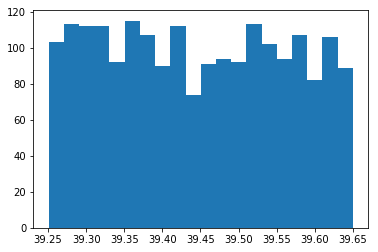

In [4]:
plt.hist(p.a, bins = 20)

(array([  5.,  15.,  19.,  41.,  84., 152., 182., 242., 256., 266., 223.,
        217., 130.,  86.,  35.,  25.,  14.,   1.,   4.,   3.]),
 array([0.26894546, 0.27237329, 0.27580112, 0.27922894, 0.28265677,
        0.2860846 , 0.28951242, 0.29294025, 0.29636808, 0.2997959 ,
        0.30322373, 0.30665156, 0.31007938, 0.31350721, 0.31693504,
        0.32036287, 0.32379069, 0.32721852, 0.33064635, 0.33407417,
        0.337502  ]),
 <a list of 20 Patch objects>)

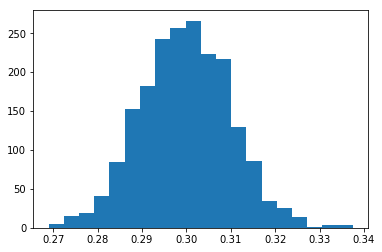

In [5]:
plt.hist(p.e, bins = 20)

(array([ 91., 221., 292., 361., 316., 232., 163., 134.,  74.,  59.,  27.,
         18.,   6.,   2.,   1.,   2.,   0.,   0.,   0.,   1.]),
 array([ 0.19536927,  3.59607841,  6.99678755, 10.39749668, 13.79820582,
        17.19891496, 20.5996241 , 24.00033324, 27.40104238, 30.80175151,
        34.20246065, 37.60316979, 41.00387893, 44.40458807, 47.80529721,
        51.20600634, 54.60671548, 58.00742462, 61.40813376, 64.8088429 ,
        68.20955204]),
 <a list of 20 Patch objects>)

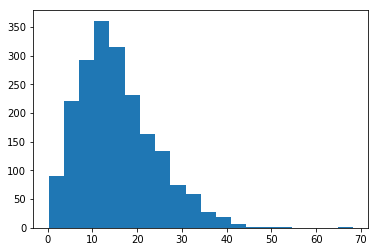

In [6]:
plt.hist(p.i*180/np.pi, bins = 20)

(array([1.00e+00, 1.00e+00, 2.00e+00, 3.00e+00, 1.80e+01, 4.50e+01,
        9.50e+01, 2.17e+02, 5.18e+02, 1.10e+03]),
 array([5.85448309, 6.26901695, 6.68355081, 7.09808467, 7.51261854,
        7.9271524 , 8.34168626, 8.75622012, 9.17075399, 9.58528785,
        9.99982171]),
 <a list of 10 Patch objects>)

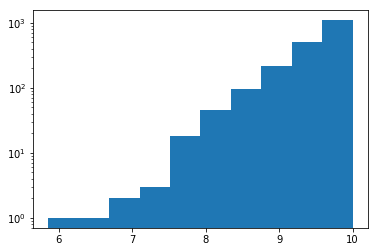

In [7]:
plt.yscale('log', bins = 20)
plt.hist(p.H)

(array([  3.,   1.,  16.,  56., 166., 310., 283., 327., 473., 365.]),
 array([21.65780693, 22.25565487, 22.85350281, 23.45135075, 24.04919868,
        24.64704662, 25.24489456, 25.8427425 , 26.44059044, 27.03843838,
        27.63628632]),
 <a list of 10 Patch objects>)

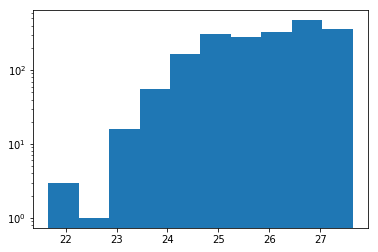

In [8]:
plt.yscale('log', bins = 20)
plt.hist(p.mag)

(array([107., 104., 101., 105., 101.,  96., 107.,  99., 101., 103., 109.,
         88.,  92., 109.,  91.,  87.,  93., 117.,  90., 100.]),
 array([1.65414877e-03, 6.29529024e-01, 1.25740390e+00, 1.88527877e+00,
        2.51315365e+00, 3.14102852e+00, 3.76890340e+00, 4.39677827e+00,
        5.02465315e+00, 5.65252802e+00, 6.28040290e+00, 6.90827777e+00,
        7.53615265e+00, 8.16402752e+00, 8.79190240e+00, 9.41977727e+00,
        1.00476521e+01, 1.06755270e+01, 1.13034019e+01, 1.19312768e+01,
        1.25591516e+01]),
 <a list of 20 Patch objects>)

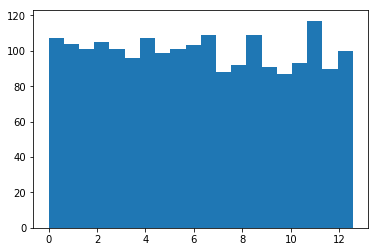

In [9]:
plt.hist(p.M, bins = 20)

(array([114., 111.,  99.,  87., 115., 109.,  93., 103.,  82.,  94., 113.,
         98., 101., 112.,  95.,  84.,  89.,  97., 104., 100.]),
 array([6.54652652e-04, 3.14700297e-01, 6.28745942e-01, 9.42791587e-01,
        1.25683723e+00, 1.57088288e+00, 1.88492852e+00, 2.19897417e+00,
        2.51301981e+00, 2.82706546e+00, 3.14111110e+00, 3.45515674e+00,
        3.76920239e+00, 4.08324803e+00, 4.39729368e+00, 4.71133932e+00,
        5.02538497e+00, 5.33943061e+00, 5.65347626e+00, 5.96752190e+00,
        6.28156755e+00]),
 <a list of 20 Patch objects>)

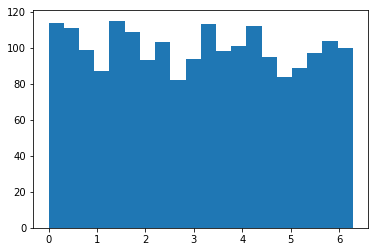

In [10]:
plt.hist(p.arg, bins = 20)

(array([109., 104.,  77., 110.,  97.,  91., 106.,  99.,  88., 109.,  84.,
        105., 106., 100., 105., 103., 113., 112.,  90.,  92.]),
 array([3.93899707e-03, 3.17862597e-01, 6.31786198e-01, 9.45709798e-01,
        1.25963340e+00, 1.57355700e+00, 1.88748060e+00, 2.20140420e+00,
        2.51532780e+00, 2.82925140e+00, 3.14317500e+00, 3.45709860e+00,
        3.77102220e+00, 4.08494580e+00, 4.39886940e+00, 4.71279300e+00,
        5.02671660e+00, 5.34064020e+00, 5.65456380e+00, 5.96848741e+00,
        6.28241101e+00]),
 <a list of 20 Patch objects>)

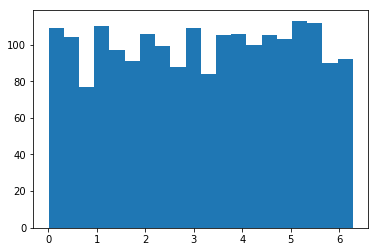

In [11]:
plt.hist(p.node, bins = 20)

(array([113., 101., 106., 105.,  94.,  97., 103.,  99.,  80.,  81., 100.,
        138.,  98.,  99., 105., 109., 110.,  85.,  86.,  91.]),
 array([0.00839614, 0.32207134, 0.63574654, 0.94942174, 1.26309694,
        1.57677214, 1.89044734, 2.20412254, 2.51779773, 2.83147293,
        3.14514813, 3.45882333, 3.77249853, 4.08617373, 4.39984893,
        4.71352413, 5.02719933, 5.34087453, 5.65454973, 5.96822493,
        6.28190013]),
 <a list of 20 Patch objects>)

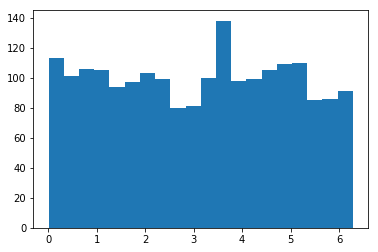

In [12]:
plt.hist((p.arg+p.node) % (2*np.pi), bins = 20)

(array([  7.,  16.,  36.,  69.,  99., 130., 142., 165., 173., 172., 168.,
        165., 154., 145., 126., 106.,  58.,  43.,  19.,   7.]),
 array([3.10894429, 3.11222575, 3.11550722, 3.11878869, 3.12207015,
        3.12535162, 3.12863309, 3.13191455, 3.13519602, 3.13847749,
        3.14175895, 3.14504042, 3.14832189, 3.15160335, 3.15488482,
        3.15816629, 3.16144775, 3.16472922, 3.16801069, 3.17129215,
        3.17457362]),
 <a list of 20 Patch objects>)

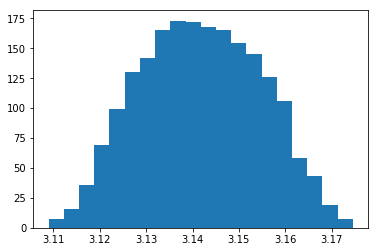

In [13]:
plt.hist(p.phi, bins = 20)

In [14]:
def kep_to_xyz(a, e, i, arg, node, M):
    # compute eccentric anomaly
    f = lambda E, M, e: E - e * np.sin(E) - M
    E0 = M
    E = newton(f, E0, args=(M, e))
    # compute true anomaly
    v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
    # compute the radius
    r = a * (1 - e*np.cos(E))
    # compute X,Y,Z
    X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
    Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
    Z = r * (np.sin(i) * np.sin(arg + v))
    return X, Y, Z

In [15]:
xn, yn, zn = zip(*map(kep_to_xyz, 30+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))
x45, y45, z45 = zip(*map(kep_to_xyz, 45+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))

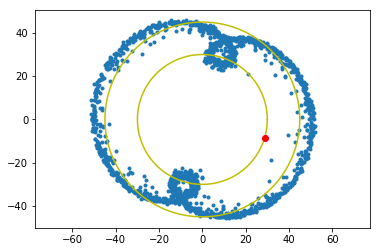

In [16]:
plt.axis('equal')
plt.scatter(p.X,p.Y, marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(p.x_n, p.y_n, 'ro')

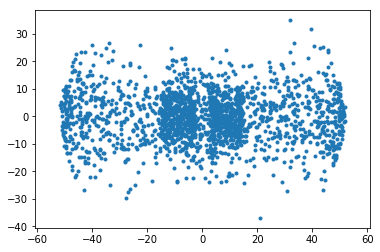

In [17]:
plt.axis('equal')
plt.scatter(p.X,p.Z, marker = '.')

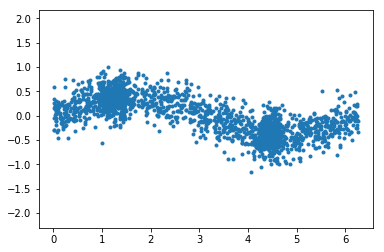

In [18]:
plt.axis('equal')
plt.scatter(p.ra,p.dec, marker = '.')

In [31]:
plutino = Scatter3d(x=p.X, y=p.Y, z=p.Z, mode='markers', marker=dict(size=1, symbol='circle'), opacity=0.7)
sun = Scatter3d(x=0, y=0, z=0, mode='markers', marker=dict(size=10, symbol='circle'), opacity=1)
neptune = Scatter3d(x=p.x_n, y=p.y_n, z=p.z_n, mode='markers', marker=dict(size=5, symbol='circle'), opacity=0.7)
fig = Figure(data=[plutino, sun, neptune])
py.iplot(fig)